In [32]:
#importing the required metrics and performance metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve

#importing warnings to suppress it wherever required
import warnings
warnings.filterwarnings('ignore')

In [33]:
#importing data file from file folder
s=pd.read_csv('/content/drive/My Drive/Micro credit/Data file.csv')

#potting the data in dataframe
credit=pd.DataFrame(s)
credit.head()

,Unnamed: 0,label,msisdn,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pcircle,pdate
0,1,0,21408I70789,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,1539,2,21.0,3078.0,1539.0,7.50,2,21,3078,1539.0,7.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000,UPW,2016-07-20
1,2,1,76462I70374,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,5787,1,0.0,5787.0,5787.0,61.04,1,0,5787,5787.0,61.04,0.0,0.0,0,0,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000,UPW,2016-08-10
2,3,1,17943I70372,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,1539,1,0.0,1539.0,1539.0,66.32,1,0,1539,1539.0,66.32,0.0,0.0,0,0,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000,UPW,2016-08-19
3,4,1,55773I70781,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,947,0,0.0,0.0,0.0,0.00,1,0,947,947.0,2.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000,UPW,2016-06-06
4,5,1,03813I82730,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,2309,7,2.0,20029.0,2309.0,29.00,8,2,23496,2888.0,35.00,0.0,0.0,0,0,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333,UPW,2016-06-22


In [34]:
credit.shape

(209593, 37)

In [35]:
#getting info of each feature
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            209593 non-null  int64  
 1   label                 209593 non-null  int64  
 2   msisdn                209593 non-null  object 
 3   aon                   209593 non-null  float64
 4   daily_decr30          209593 non-null  float64
 5   daily_decr90          209593 non-null  float64
 6   rental30              209593 non-null  float64
 7   rental90              209593 non-null  float64
 8   last_rech_date_ma     209593 non-null  float64
 9   last_rech_date_da     209593 non-null  float64
 10  last_rech_amt_ma      209593 non-null  int64  
 11  cnt_ma_rech30         209593 non-null  int64  
 12  fr_ma_rech30          209593 non-null  float64
 13  sumamnt_ma_rech30     209593 non-null  float64
 14  medianamnt_ma_rech30  209593 non-null  float64
 15  

It seems from the info that there is no presence of null values in the dataset

In [36]:
#here we have to remove some of the columns that are not adding any value to the prediction such as unnamed
#unnamed,msisdn are unique
#pcircle has only one value throughout the data and date is not needed when we have previous 30 days and 90 days data
credit.drop(['Unnamed: 0','msisdn','pcircle','pdate'],axis=1,inplace=True)

In [37]:
#checking the data counts
credit['label'].value_counts()

1    183431
0     26162
Name: label, dtype: int64

The ratio b/w label 1 and label 0 clearly shows that this is a imbalanced dataset

We have some of the feature that are in the form of indonesian currency,so lets convert it first to indian rupee to scale it all in same unit

In [38]:
ind=['daily_decr30','daily_decr90','last_rech_amt_ma','sumamnt_ma_rech30','medianamnt_ma_rech30','medianmarechprebal30']
for i in ind:
  credit[i] = 0.0052 *credit[i]

In [39]:
credit.head()

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
0,0,272.0,15.886260,15.938780,220.13,260.13,2.0,0.0,8.0028,2,21.0,16.0056,8.0028,0.039000,2,21,3078,1539.0,7.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000
1,1,712.0,63.034400,63.048700,3691.26,3691.26,20.0,0.0,30.0924,1,0.0,30.0924,30.0924,0.317408,1,0,5787,5787.0,61.04,0.0,0.0,0,0,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000
2,1,535.0,7.269600,7.269600,900.13,900.13,3.0,0.0,8.0028,1,0.0,8.0028,8.0028,0.344864,1,0,1539,1539.0,66.32,0.0,0.0,0,0,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000
3,1,241.0,0.110386,0.110386,159.42,159.42,41.0,0.0,4.9244,0,0.0,0.0000,0.0000,0.000000,1,0,947,947.0,2.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000
4,1,947.0,0.783221,0.783221,1098.90,1098.90,4.0,0.0,12.0068,7,2.0,104.1508,12.0068,0.150800,8,2,23496,2888.0,35.00,0.0,0.0,0,0,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333


In [40]:
#statistical summary of the dataset
credit.describe()

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
count,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.00000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000
mean,0.875177,8112.343445,27.983292,31.629078,2692.581910,3483.406534,3755.847800,3712.202921,10.735155,3.978057,3737.355121,40.063406,9.426653,20.030025,6.31543,7.716780,12396.218352,1864.595821,92.025541,262.578110,3749.494447,0.041495,0.045712,2.758981,17.952021,274.658747,0.054029,18.520919,23.645398,6.703134,0.046077,3.398826,4.321485
std,0.330519,75696.082531,47.947242,56.777826,4308.586781,5770.461279,53905.892230,53374.833430,12.328087,4.256090,53643.625172,52.726033,10.768496,280.833147,7.19347,12.590251,16857.793882,2081.680664,369.215658,4183.897978,53885.414979,0.397556,0.951386,2.554502,17.379741,4245.264648,0.218039,224.797423,26.469861,2.103864,0.200692,8.813729,10.308108
min,0.000000,-48.000000,-0.483666,-0.483666,-23737.140000,-24720.580000,-29.000000,-29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.040000,0.00000,0.000000,0.000000,0.000000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,246.000000,0.220688,0.221998,280.420000,300.260000,1.000000,0.000000,4.004000,1.000000,0.000000,8.008000,4.004000,0.057200,2.00000,0.000000,2317.000000,773.000000,14.600000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,0.000000,1.000000,6.000000,6.000000,0.000000,0.000000,0.000000
50%,1.000000,527.000000,7.639713,7.800000,1083.570000,1334.000000,3.000000,0.000000,8.002800,3.000000,2.000000,24.065600,8.002800,0.176280,4.00000,2.000000,7226.000000,1539.000000,36.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,6.000000,0.000000,2.000000,12.000000,6.000000,0.000000,0.000000,1.666667
75%,1.000000,982.000000,37.668800,40.574508,3356.940000,4201.790000,7.000000,0.000000,12.006800,5.000000,6.000000,52.052000,10.004800,0.431600,8.00000,8.000000,16000.000000,1924.000000,79.310000,0.000000,0.000000,0.000000,0.000000,4.000000,24.000000,6.000000,0.000000,5.000000,30.000000,6.000000,0.000000,3.750000,4.500000
max,1.000000,999860.755168,1382.815200,1667.276000,198926.110000,200148.110000,998650.377733,999171.809410,286.000000,203.000000,999606.368132,4212.499200,286.000000,5197.292980,336.00000,88.000000,953036.000000,55000.000000,41456.500000,99914.441420,999809.240107,38.000000,64.000000,50.000000,306.000000,99864.560864,3.000000,4997.517944,438.000000,12.000000,3.000000,171.500000,171.500000


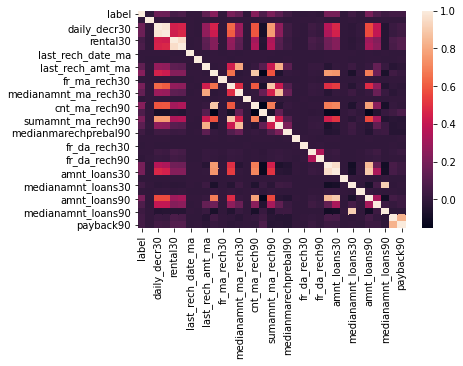

In [41]:
#plotting the correlation heatmap
sns.heatmap(credit.corr())

From the describe column,we see there is presence of outliers in each and every feature here,Lets apply z-score to reduce some

In [42]:
#applying zscore
from scipy.stats import zscore
z=np.abs(zscore(credit))
credit_new=credit[(z<3).all(axis=1)]
credit_new.shape

(161465, 33)

We see after applying zscore,we get huge reduce in rows size and column too,so taking it as a primary dataset for processing

In [43]:
credit=credit_new
credit

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
0,0,272.0,15.886260,15.938780,220.13,260.13,2.0,0.0,8.0028,2,21.0,16.0056,8.0028,0.039000,2,21,3078,1539.0,7.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000
1,1,712.0,63.034400,63.048700,3691.26,3691.26,20.0,0.0,30.0924,1,0.0,30.0924,30.0924,0.317408,1,0,5787,5787.0,61.04,0.0,0.0,0,0,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000
2,1,535.0,7.269600,7.269600,900.13,900.13,3.0,0.0,8.0028,1,0.0,8.0028,8.0028,0.344864,1,0,1539,1539.0,66.32,0.0,0.0,0,0,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000
3,1,241.0,0.110386,0.110386,159.42,159.42,41.0,0.0,4.9244,0,0.0,0.0000,0.0000,0.000000,1,0,947,947.0,2.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000
4,1,947.0,0.783221,0.783221,1098.90,1098.90,4.0,0.0,12.0068,7,2.0,104.1508,12.0068,0.150800,8,2,23496,2888.0,35.00,0.0,0.0,0,0,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209588,1,404.0,0.789736,0.789736,1089.19,1089.19,1.0,0.0,21.0496,3,2.0,54.1008,16.5256,0.477412,3,2,10404,3178.0,91.81,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,1.000000,1.000000
209589,1,1075.0,0.192067,0.192067,1728.36,1728.36,4.0,0.0,4.0196,4,1.0,16.0784,4.0196,0.838760,6,2,4038,773.0,111.80,0.0,0.0,0,0,3,18,6.0,0.0,3.0,18,6,0.0,1.000000,1.000000
209590,1,1013.0,61.584181,61.902620,5861.83,8893.20,3.0,0.0,8.0028,5,8.0,48.5368,8.0028,0.265876,11,5,18592,1539.0,47.13,0.0,0.0,0,0,4,42,12.0,0.0,6.0,54,12,0.0,4.000000,3.833333
209591,1,1732.0,64.938787,65.386724,411.83,984.58,2.0,38.0,4.0196,5,4.0,63.2008,4.0196,0.852800,6,4,17941,2410.5,100.00,0.0,0.0,1,0,2,18,12.0,0.0,3.0,24,12,0.0,0.000000,10.500000


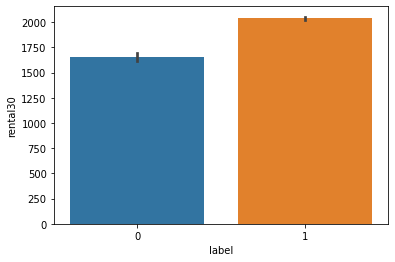

In [44]:
#plotting a data to visualize labels with rental30
sns.barplot('label','rental30',data=credit)

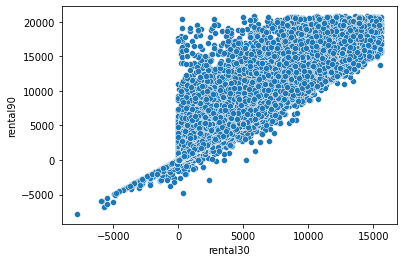

In [45]:
sns.scatterplot('rental30','rental90',data=credit)

Dividing independent and dependant data from the dataset

In [46]:
des_x=credit.iloc[:,1:]
y=credit.iloc[:,0]
print(des_x.shape)
print(y.shape)

(161465, 32)
(161465,)


In [47]:
#applying standard scaler to the input data
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
mod_x=scale.fit_transform(des_x)
x=pd.DataFrame(mod_x,columns=des_x.columns)
x.head()

,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
0,-0.753989,-0.126467,-0.169679,-0.644046,-0.635286,-0.411410,-0.119438,-0.129929,-0.468416,3.116889,-0.478194,-0.020133,-0.433767,-0.663040,1.337962,-0.635883,-0.046800,-0.527748,-0.020514,0.0,-0.141331,0.0,-0.271757,-0.324496,-0.022490,-0.180636,-0.431731,-0.460004,-0.331915,-0.159769,6.238367,5.206904
1,0.132221,1.475220,1.235024,0.622504,0.338713,1.463090,-0.119438,2.235934,-0.792341,-0.718641,-0.032911,2.642042,-0.098841,-0.865668,-0.643145,-0.357580,2.619794,-0.082660,-0.020514,0.0,-0.141331,0.0,-0.796389,-0.324496,0.008528,-0.180636,-0.783344,-0.460004,3.012819,-0.159769,-0.619352,-0.647060
2,-0.224277,-0.419187,-0.428173,-0.395927,-0.453609,-0.307271,-0.119438,-0.129929,-0.792341,-0.718641,-0.731162,-0.020133,-0.065811,-0.865668,-0.643145,-0.793989,-0.046800,-0.038766,-0.020514,0.0,-0.141331,0.0,-0.796389,-0.816438,-0.022490,-0.180636,-0.783344,-0.794570,-0.331915,-0.159769,-0.619352,-0.647060
3,-0.816426,-0.662396,-0.641644,-0.666198,-0.663875,3.650007,-0.119438,-0.459635,-1.116266,-0.718641,-0.984130,-0.984607,-0.480684,-0.865668,-0.643145,-0.854806,-0.418415,-0.569314,-0.020514,0.0,-0.141331,0.0,-0.271757,-0.324496,-0.022490,-0.180636,-0.431731,-0.460004,-0.331915,-0.159769,-0.619352,-0.647060
4,0.605537,-0.639539,-0.621581,-0.323399,-0.397184,-0.203132,-0.119438,0.298911,1.151207,-0.353352,2.308071,0.462418,-0.299271,0.552727,-0.454469,1.461713,0.800007,-0.299135,-0.020514,0.0,-0.141331,0.0,2.351404,2.135213,-0.022490,-0.180636,1.326336,1.212825,-0.331915,-0.159769,-0.067581,-0.176051


In [48]:
#function for determining random state
def random(alg):
    r_state=0
    for r_score in range(43,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=r_score)
        alg.fit(x_train,y_train)
        pred=alg.predict(x_test)
        accuracy=accuracy_score(y_test,pred)
        if accuracy > r_state:
            r_state=accuracy
            final_r=r_score
    print(r_state,'at',final_r)

In [49]:
#roc_curve
def roc(alg):
    y_pred_prob=alg.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr)
    plt.xlabel('false_Positive_rate')
    plt.ylabel('True positive rate')
    plt.title(alg)
    plt.show()
    roc_score=roc_auc_score(y_test,alg.predict(x_test))
    print('roc_auc_score=',roc_score)

Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
random(lr)

0.8672209293596577 at 55


In [51]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=55)
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
score=lr.score(x_train,y_train)
print('score=',score)
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

score= 0.8628687107717622
0.8672209293596577
[[  680  6561]
 [  514 45529]]
              precision    recall  f1-score   support

           0       0.57      0.09      0.16      7241
           1       0.87      0.99      0.93     46043

    accuracy                           0.87     53284
   macro avg       0.72      0.54      0.54     53284
weighted avg       0.83      0.87      0.82     53284



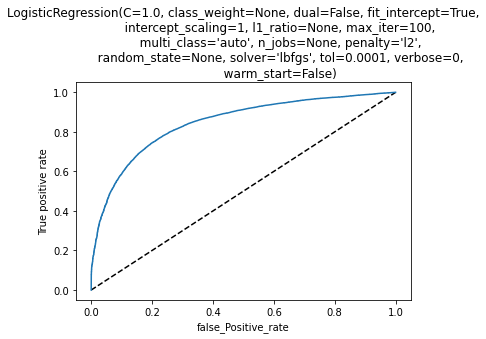

roc_auc_score= 0.5413731016822709


In [52]:
roc(lr)

In [53]:
from sklearn.linear_model import Lasso
ls=Lasso()
alphavalues={'alpha':[1,0.1,0.01,0.001]}
grid=GridSearchCV(estimator=ls,param_grid=alphavalues)

In [54]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=43)

In [55]:
grid.fit(x_train,y_train)
print(grid.best_params_)

{'alpha': 0.001}


In [56]:
ls=Lasso(alpha=0.001)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)

0.16518343308958205

From the above score of lasso,its not good to proceed with Lasso

Applying Oversampling Techniques

In [57]:
#splitting to train & test for oversampling
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)

In [58]:
#applying imbalanced learn library modules
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(0.75)
x_train_ns, y_train_ns = os.fit_sample(x_train, y_train)

os_rf = RandomForestClassifier()
os_rf.fit(x_train_ns, y_train_ns)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
y_pred = os_rf.predict(x_test)

print('Confustion Matrix : \n\n', confusion_matrix(y_test,y_pred))
print('\n Accuracy Score : ',   accuracy_score(y_test,y_pred))
print('\n Classification Report : \n \n', classification_report(y_test,y_pred))

Confustion Matrix : 

 [[ 4012  3338]
 [ 1782 44152]]

 Accuracy Score :  0.9039111177839502

 Classification Report : 
 
               precision    recall  f1-score   support

           0       0.69      0.55      0.61      7350
           1       0.93      0.96      0.95     45934

    accuracy                           0.90     53284
   macro avg       0.81      0.75      0.78     53284
weighted avg       0.90      0.90      0.90     53284



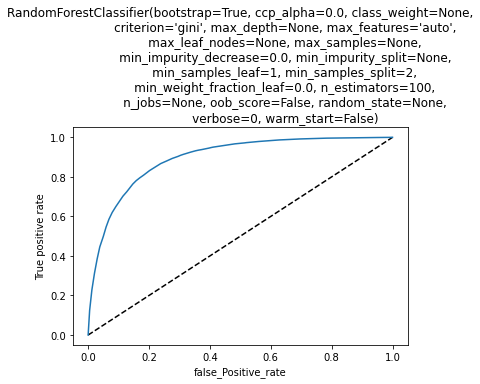

roc_auc_score= 0.753527773803822


In [60]:
roc(os_rf)

Here we get scores most specified for imbalanced dataset above to 0.55 and ROC score is also 0.75.This model also performs good as per this data.

SMOTETomek

In [61]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(0.75)

x_train_ns, y_train_ns = smt.fit_sample(x_train,y_train)
smt_rf=RandomForestClassifier()
smt_rf.fit(x_train_ns, y_train_ns)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
y_pred = smt_rf.predict(x_test)

print('Confustion Matrix : \n\n', confusion_matrix(y_test,y_pred))
print('\n Accuracy Score : ',   accuracy_score(y_test,y_pred))
print('\n Classification Report : \n \n', classification_report(y_test,y_pred))

Confustion Matrix : 

 [[ 4425  2925]
 [ 2777 43157]]

 Accuracy Score :  0.8929885143757976

 Classification Report : 
 
               precision    recall  f1-score   support

           0       0.61      0.60      0.61      7350
           1       0.94      0.94      0.94     45934

    accuracy                           0.89     53284
   macro avg       0.78      0.77      0.77     53284
weighted avg       0.89      0.89      0.89     53284



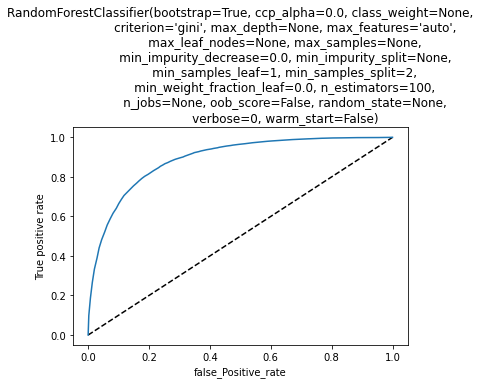

roc_auc_score= 0.7707922547257245


In [65]:
roc(smt_rf)

### Conclusion
The best techniques to handle this dataset is:

1.Random forest with oversampling

2.SmoteTomek